# SI 630 Project Code

In [1]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

#Sklearn is for machine learning 
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

import pandas as pd
import seaborn as sns

import spacy

# loading up the language model: English
# Windows users will need to follow the instructions in Slack to modify the next line
nlp = spacy.load(r'C:\Users\jaina\Anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.0.0')
from spacy.lang.en.stop_words import STOP_WORDS


In [3]:
#import the files
df=pd.read_csv('data/source.csv', encoding = "ISO-8859-1")

df.head()

,textID,country|genre,# words,web site,web page,title
0,3283052,AU B,483,adoreanimals.com,http://adoreanimals.com/articles/new-technique...,New techniques for managing wild elephants | A...
1,3284350,AU B,1455,asopa.typepad.com,http://asopa.typepad.com/asopa_people/2012/07/...,Development - or what do our people really wan...
2,3284352,AU B,202,asopa.typepad.com,http://asopa.typepad.com/asopa_people/2012/07/...,Indonesia-PNG draft agreement to bring back Dj...
3,3284452,AU B,635,asopa.typepad.com,http://asopa.typepad.com/asopa_people/2012/11/...,Privatising state enterprises: benefits &amp; ...
4,3285550,AU B,611,bellyrumbles.com,http://bellyrumbles.com/2012/10/are-you-austra...,Are you Australia's best home chef? | Belly Ru...


In [4]:
#split country from genre column

new=df['country|genre'].str.split(' ', n=1, expand=True)

df['country']=new[0]
df['genre']=new[1]

df.drop(columns=['country|genre'], inplace=True)

df.head()

,textID,# words,web site,web page,title,country,genre
0,3283052,483,adoreanimals.com,http://adoreanimals.com/articles/new-technique...,New techniques for managing wild elephants | A...,AU,B
1,3284350,1455,asopa.typepad.com,http://asopa.typepad.com/asopa_people/2012/07/...,Development - or what do our people really wan...,AU,B
2,3284352,202,asopa.typepad.com,http://asopa.typepad.com/asopa_people/2012/07/...,Indonesia-PNG draft agreement to bring back Dj...,AU,B
3,3284452,635,asopa.typepad.com,http://asopa.typepad.com/asopa_people/2012/11/...,Privatising state enterprises: benefits &amp; ...,AU,B
4,3285550,611,bellyrumbles.com,http://bellyrumbles.com/2012/10/are-you-austra...,Are you Australia's best home chef? | Belly Ru...,AU,B


## Data Exploration

In [51]:
len(df)

1650

In [2]:
trans_dict={'AU':'Australia', 'BD':'Bangladesh', 'CA':'Canada', 'GH':'Ghana', 'GB':"Great Britian", 'HK':'Hong Kong', 'IN':'India', 'IE':'Ireland', 'JM':'Jamacia', 'KE':'Kenya', 'MY':'Malaysia', 'NZ':'New Zeland', 'NG':'Nigeria', 'PH':'Philippines', 'PK':'Pakistan', 'SG':'Singapore', 'LK':'Sri Lanka', 'ZA':'South Africa', 'TZ':'Tanzania', 'US':'United States'}

In [112]:
country_names=trans_dict.values()

In [115]:
country_names=[i for i in country_names]

In [117]:
country_names[0:5]

['Australia', 'Bangladesh', 'Canada', 'Ghana', 'Great Britian']

In [122]:
country_name=[]

In [123]:
code=[]
for i in cnt_pro.index:
    country=trans_dict[i]
    country_name.append(country)
    code.append(country)

In [124]:
print(country_name[0:5])

['Great Britian', 'United States', 'Australia', 'Canada', 'Ireland']


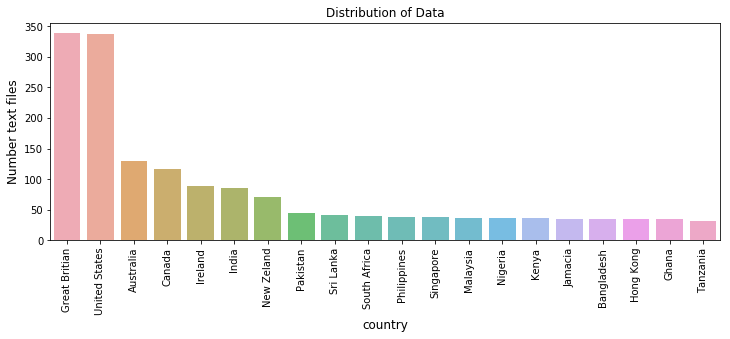

In [11]:
cnt_pro = df['country'].value_counts()
plt.figure(figsize=(12,4))
svm=sns.barplot(code, cnt_pro.values, alpha=0.8)
plt.ylabel('Number text files', fontsize=12)
plt.xlabel('country', fontsize=12)
plt.xticks(rotation=90)
plt.title('Distribution of Data')
plt.savefig('country.pdf',format='pdf')#saves the figure in the data folder

figure = svm.get_figure()    
figure.savefig('svm_conf.pdf', dpi=400)

plt.show();
# plt.savefig('country.pdf',format='pdf')#saves the figure in the data folder

In [53]:
df['# words'].sum()

2058127

In [11]:
df['# words'].mean()

1247.3496969696969

## Doc2Vec Model

In [15]:
import gensim
import os
import collections
import smart_open
import random

C:\Users\jaina\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [12]:
#types of files countires
countires=['au','bd','ca','gb','hk','ie','in','jm','ke','my','ng','nz','ph','pk','sg','tz','us','za']


In [25]:
# clean_text

In [149]:
#list for the actual country for the test corpus
test_actual=[]
train_actual=[]


def read_corpus(country, tokens_only=False, both=False):
    c_index=countires.index(country)
#     print(c_index)
    if tokens_only:
#         fname='data/w_'+str(country)+'_b.txt'
        fname='data/w_'+str(country)+'_b.txt'
    if both:
        fname='data/w_'+str(country)+'_b.txt'
    else:
#         fname='data/w_'+str(country)+'_g.txt'
        fname='data/w_'+str(country)+'_b.txt'
    with smart_open.smart_open(fname, encoding="utf-8") as f:
        for i, line in enumerate(f):
            if tokens_only:
                test_actual.append(c_index)
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                train_actual.append(c_index)
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), tags=[c_index])

In [151]:
train_list=[]
test_list=[]
total_list=[]

for x in countires:
    if x == 'gb' or x=='us':
        train_corpus=list(read_corpus(x))
        train_list.extend(train_corpus)

        test_corpus=list(read_corpus(x, tokens_only=True))
        test_list.extend(test_corpus)
    else:
        for num in range(30):
            train_corpus=list(read_corpus(x, both=True))
            train_list.extend(train_corpus)

        test_corpus=list(read_corpus(x, tokens_only=True))
        test_list.extend(test_corpus)
    

In [124]:
# train_actual

In [152]:
#Doc2Vec Object
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40, dm =1)

In [153]:
#build vocab
model.build_vocab(train_list)

In [154]:
#train model
model.train(train_list, total_examples=model.corpus_count, epochs=model.epochs)

In [180]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_list) - 1)
# doc_id=502
inferred_vector = model.infer_vector(test_list[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

In [172]:
print(test_actual[doc_id])

4


In [157]:
sims

[(17, 0.9048422574996948),
 (16, 0.6791102290153503),
 (15, 0.6789793968200684),
 (11, 0.633898138999939),
 (12, 0.6321077346801758),
 (7, 0.6173979043960571),
 (3, 0.6135717630386353),
 (4, 0.5958582162857056),
 (8, 0.5827701687812805),
 (13, 0.5806625485420227),
 (10, 0.5412666201591492),
 (5, 0.539499044418335),
 (14, 0.5369576215744019),
 (9, 0.5291302800178528),
 (1, 0.5216469764709473),
 (0, 0.474743127822876),
 (2, 0.4739220440387726),
 (6, 0.4662554860115051)]

In [68]:
index=10
train_actual[sims[index][0]]

0

In [65]:
len(train_list)

1102

In [ ]:
# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}){}: «{}»\n'.format(doc_id,country_name[train_actual[doc_id]], ' '.join(test_list[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s %s' % (label, sims[index],country_name[train_actual[sims[index][0]]]))

## F1 score testing

In [162]:
len(test_list)

509

In [163]:
len(test_actual)

509

In [165]:
print(test_actual[0:100])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [164]:
#list of actual test classification
y_test=test_actual

In [166]:
#list of predictions from test 
y_pred=[]
#obtain predictions

for num in range(len(test_list)):
    doc_id=num
#     print(num)
    inferred_vector = model.infer_vector(test_list[doc_id])
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
#     y_pred.extend()
#     print(sims)

    for label, index in [sims[0]]:
#         print(label)
#         print(index)
#         print(train_actual[label])
#         print(label)
        actual=test_actual[label]
        y_pred.append(actual)

In [167]:
print(y_pred[0:100])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [168]:
print(y_test[0:100])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [169]:
print(len(y_pred))

509


In [25]:
#calc the F1 score
from sklearn.metrics import accuracy_score, f1_score

In [170]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.07662082514734773


C:\Users\jaina\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Testing F1 score: 0.010905883871337816
